## Project 1
#### Eva Fong (xsg5by), Angelika Baloy (ybm4rn), Olivia Pang (pme3nf), Shreya Shanmugan (ney3yp), Smera Shanmugan (pjt7xx)

### Part 1:

In [ ]:
import pandas as pd
mdf = pd.read_csv('/content/linked_mortality_file_1999_2000.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("/content/DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable

   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0      23.0   
4   5.0       1.0       2.0       2.

#### Documentation for `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT` and `RIDAGEEX`
- `ELIGSTAT`: The eligiblity status of an observation for mortality follow-up. Has three possible values of 1 for "Eligible", 2 for "Under age 18, not available for public release", and 3 for "Ineligible".

- `MORTSTAT`: The final mortality status of an observation. Has three possible values of 0 for "Assumed alive", 1 for "Assumed dead", and . for "Assumed alive, under 18, ineligible for mortality follow-up, or MCOD not available".

- `PERMTH_INT`: The number of months of follow-up from NHANES interview date. Possible integer values from 43 to 45.

- `RIDAGEEX`: Age in months at date of examination for individuals under 85 years of age at screening.

In [ ]:
body = pd.read_sas("/content/BMX.xpt", format="xport")
occupation = pd.read_sas("/content/OCQ.xpt", format="xport")
blood_pressure = pd.read_sas("/content/BPX.xpt", format="xport")
heart = pd.read_sas("/content/CDQ.xpt", format="xport")


#### Rationale for data selections

From the 2000-1999 NHANES data page, we are going to be using data on age, sex, education, income (DEMO), BMI (BMX), occupation (OCQ), blood pressure (BPQ), and heart condition (CDQ).

We chose these data because we are interested to see the influence of social-economic status on someone's mortality in addition to their health metrics. Age is, of course, is included as a part of our variable set as it is proven to be highly correlated to morality by research and by the exercises we did in class. Sex is also included to account for possible biological differences that might aid or hinder someone's life expectancy.

Education, income, and occupation serve as the indicators for socioeconomic influences. The three together typically captures someone's access to human capital and resources available to them.

Finally, BMI, blood pressure, and heart conditions will help us identify the correlation between possible physiological risk factors and morality.

In [ ]:
df = df.merge(body, on="SEQN", how="left")
df = df.merge(occupation, on="SEQN", how="left")
df = df.merge(blood_pressure, on="SEQN", how="left")
df = df.merge(heart, on="SEQN", how="left")

In [ ]:
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0
BMAUPREL,9965
BMAUPLEL,9965
BMIHEAD,9964
BMALLKNE,9964
DMARACE,9963
...,...
RIDAGEMN,173
DMDHRAGE,12
DMDHRGND,12
DMDBORN,11


In the merged dataset, there are a total of 147 columns that have missing values, but that is expected given the sheer size of the dataset.

To make documentation easier, we will only consider the missing values of the specific variables that we want to use.

In [ ]:
var_set = [
    "ELIGSTAT", "MORTSTAT", "PERMTH_INT", #eligiblity, mortality status, months since follow-up
    "RIDAGEEX", #age
    "RIAGENDR", #sex
    "DMDEDUC2", #highest grade or level completed
    "INDFMPIR", #ratio of family income to poverty
    "BMXBMI", #body mass index
    "BPXSY1", #blood pressure, specifically pressure in artieries when heart beats
    "OCQ150", #type of work done last week
]

df_altered = df[var_set]
df_altered = df_altered[df_altered["ELIGSTAT"] == 1] #we will only be analyzing the participants that are eligible
missing_altered = df_altered.isnull().sum()
missing_altered[missing_altered > 0].sort_values(ascending=False)

#df_altered['RIDAGEEX'].describe()

,0
BPXSY1,1107
INDFMPIR,841
RIDAGEEX,605
DMDEDUC2,570
BMXBMI,545
OCQ150,2


#### Missing values

`BPXSY1` (blood pressure): this variable has the most missing values, likely to due participants who might've been unwilling to partake in a clinical examination

`INDFMPIR` (family income to poverty ratio): this missing values may be due to the people who provide their income to the survey

`RIDGEEX` (age): this is rather unusual, maybe a human or technical error, but should remove the observations with missing age

`BMXBMI` (BMI): again, could be missing due to participants not willing to undergo clinical examination


`OCQ150` (type of work done last week): only two missing, which means those two may just be non-responses

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# convert to df and removed observations with missing age
df_altered = pd.DataFrame(df_altered.dropna(subset=['RIDAGEEX']))

We are working with a total of 7 variables to predict mortality (MORTSTAT) and life expectancy (PERMTH_INT). First, I'd like to explore these two variables.

In [ ]:
# MORTSTAT
df_altered['MORTSTAT'].value_counts()
# After wrangling, we are left with 3770 "Assumed alive" (0) and 1675 "Assumed dead" (1)
# This will function as a categorical variable in subsequent analyses.

,count
MORTSTAT,
0.0,3508
1.0,1332


In [ ]:
# PERMTH_INT
df_altered['PERMTH_INT'].describe() # descriptive statistics for life expectancy
# The mean is lower than the median, suggesting a negative skew
# We can expect values ranging from 0 to 250, which I'm assuming is a cutoff

,PERMTH_INT
count,4840.000000
mean,208.880165
std,60.687650
min,1.000000
25%,221.000000
50%,236.000000
75%,243.000000
max,250.000000


<Axes: xlabel='PERMTH_INT', ylabel='Count'>

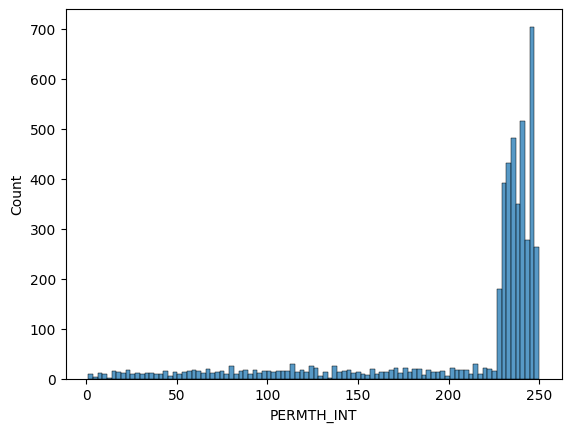

In [ ]:
# PERMTH_INT Histogram
sns.histplot(df_altered['PERMTH_INT'])
# After creating a visualization, it is clear that most have 230+ months life expectancy,
# or survive until the end of the mortality period

<Axes: xlabel='PERMTH_INT', ylabel='Density'>

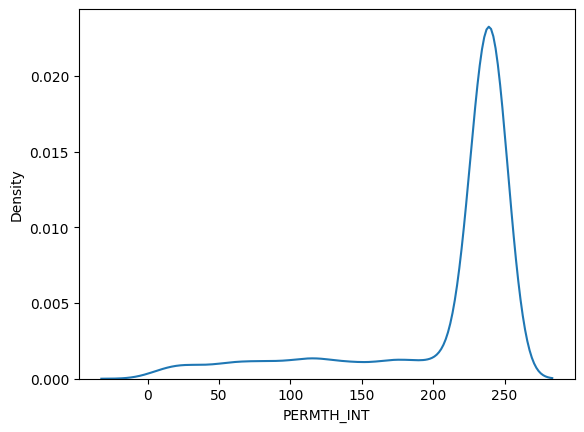

In [ ]:
sns.kdeplot(data=df_altered['PERMTH_INT'])
# This reiterates what we've discovered with the previous histogram, but this kdeplot gives us
# a better idea of proportions. This distribution will be important to reference once we create
# our prediction models.

Next, on to our variables of interest: Age (RIDAGEEX), Gender (RIAGENDR), Education Level (DMDEDUC2), Family Poverty Income Ratio (INDFMPIR), Body Mass Index (BMXBMI), Systolic Blood Pressure (BPXSY1), and Occupation type (OCQ150).

In [ ]:
# Age (in months)
df_altered['RIDAGEEX'].describe()


,RIDAGEEX
count,4840.000000
mean,553.576240
std,235.457568
min,216.000000
25%,343.750000
50%,530.000000
75%,758.000000
max,1019.000000


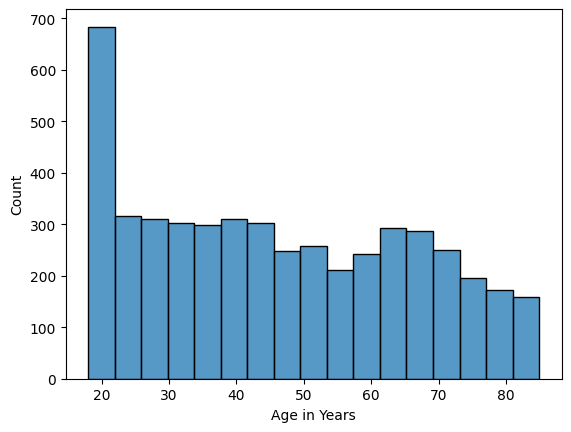

In [ ]:
# Visualizing Age (in Years)
age_years = df_altered['RIDAGEEX']/12
sns.histplot(age_years)
plt.xlabel("Age in Years")
plt.show()
# Most of the people in the dataset were on the younger side.

In [ ]:
# Gender
df_altered['RIAGENDR'].value_counts() # Close to even split between genders (1=Male/2=Female)

,count
RIAGENDR,
2.0,2568
1.0,2272


In [ ]:
# Education Level
df_altered['DMDEDUC2'].value_counts() # Distribution of education level
# Most are either high school graduates or obtained some college or Associates

,count
DMDEDUC2,
3.0,981
4.0,964
2.0,859
1.0,794
5.0,699
9.0,9
7.0,3


In [ ]:
# Family Poverty Income Ratio
df_altered['INDFMPIR'].describe() # range= 0 to 5

,INDFMPIR
count,4.153000e+03
mean,2.440135e+00
std,1.607828e+00
min,5.397605e-79
25%,1.070000e+00
50%,2.040000e+00
75%,3.880000e+00
max,5.000000e+00


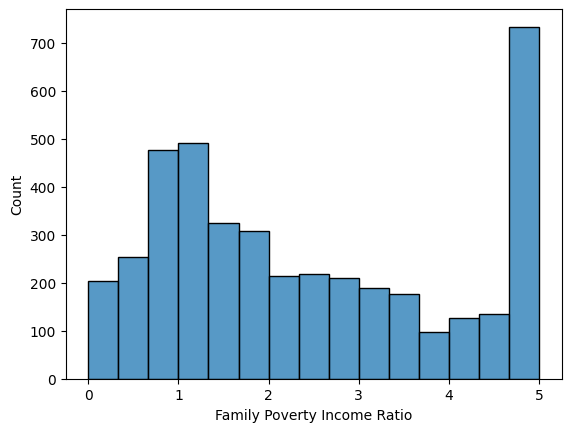

In [ ]:
# Family PIR Histogram
sns.histplot(df_altered['INDFMPIR'])
plt.xlabel("Family Poverty Income Ratio")
plt.show()
# Appears to be bimodal, with two distinct peaks around 1 and 5 (ceiling effect, like PERMTH_INT)
# This reveals that most families' income was similar to the poverty line or far exceeded it.


In [ ]:
# BMXBMI
df_altered['BMXBMI'].describe() # 12.04 to 66.44

,BMXBMI
count,4781.000000
mean,28.105451
std,6.294096
min,12.040000
25%,23.700000
50%,27.050000
75%,31.450000
max,66.440000


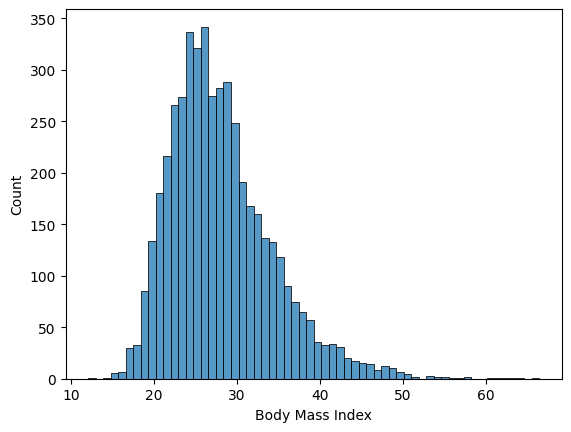

In [ ]:
# BMI Visualization
sns.histplot(df_altered['BMXBMI'])
plt.xlabel("Body Mass Index")
plt.show()

Because of this spread and positive skew, I create a boxplot to see if there are any upper outliers.

<Axes: xlabel='BMXBMI'>

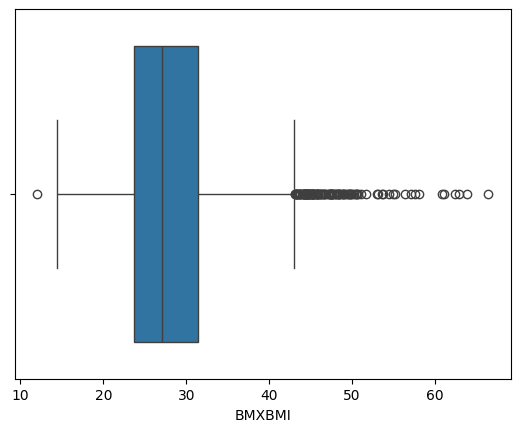

In [ ]:
sns.boxplot(x=df_altered['BMXBMI'])
# There are many upper outliers as well as one lower outlier

BMI is tricky because of how BMI categories are set up. Anything outside of 18.5-24.9 is considered potentially problematic to one's health (though BMI as a measure of the quality of one's health is debatable). I create another histogram to help us visualize the BMI categories.

In [ ]:
BMI_cat = df_altered['BMXBMI']

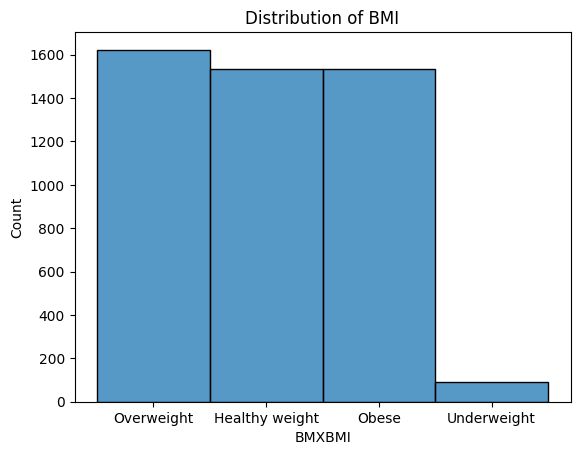

In [ ]:
# Function to categorize BMI values
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 24.9:
        return 'Healthy weight'
    elif 24.9 <= bmi < 29.9:
        return 'Overweight'
    elif bmi >= 29.9:
        return 'Obese'
    else:
        return np.nan # For missing BMI values


sns.histplot(BMI_cat.apply(bmi_category))
plt.title("Distribution of BMI")
plt.show()

# We can see here that most of the sample is overweight or obese. A decent portion are
# within the healthy weight range. Few are underweight.

In [ ]:
# Systolic Blood Pressure
df_altered['BPXSY1'].describe() # ranges from 76 to 242
# 242 seems like a dangerously high number

,BPXSY1
count,4227.000000
mean,126.308020
std,22.020142
min,76.000000
25%,110.000000
50%,122.000000
75%,138.000000
max,242.000000


<Axes: xlabel='BPXSY1', ylabel='Count'>

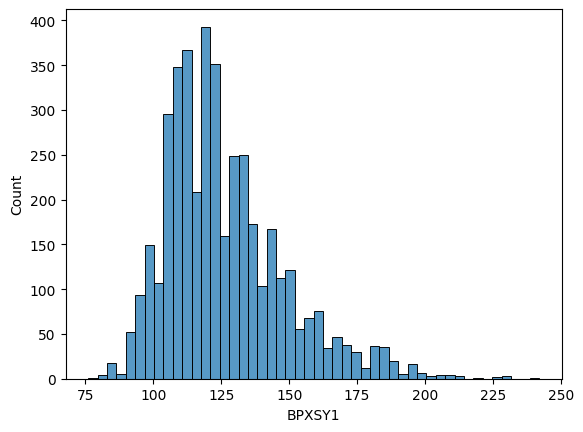

In [ ]:
# Systolic Blood Pressure Histogram
sns.histplot(df_altered['BPXSY1'])

<Axes: xlabel='BMXBMI'>

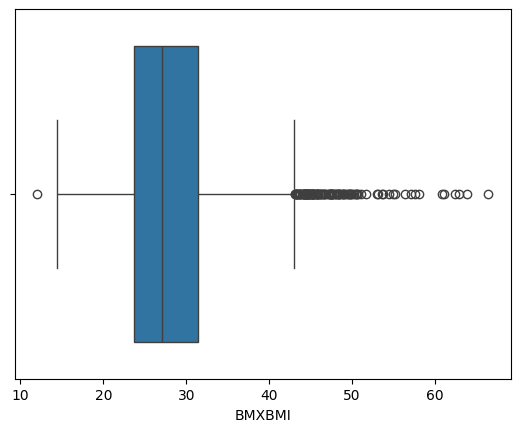

In [ ]:
# Looking for outliers
sns.boxplot(x=df_altered['BMXBMI'])
# There are several upper outliers

In [ ]:
# Occupation - type of work done last week
df_altered['OCQ150'].value_counts()
# This also functions like a categorical variable.
# Most responded 1, which means that they were working at a job or business within the
# last week. Many responded 4 as well, which means they have a job but were not present at
# work within the last week.

,count
OCQ150,
1.0,2589
4.0,2043
2.0,116
3.0,90
9.0,1
7.0,1


We can also expect to see relationships between our variables of interest.

<Axes: xlabel='RIDAGEEX', ylabel='Density'>

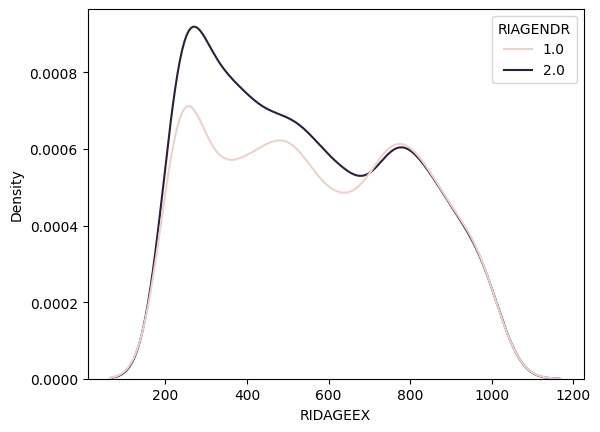

In [ ]:
# Age and Gender
sns.kdeplot(data=df_altered, x='RIDAGEEX', hue='RIAGENDR')
# Age distributions are somewhat similar between genders

In [ ]:
# Gender and Occupation
pd.crosstab(df_altered['RIAGENDR'], df_altered['OCQ150'])
# Gender does not seem to impact the type of work done

OCQ150,1.0,2.0,3.0,4.0,7.0,9.0
RIAGENDR,,,,,,
1.0,1377,55,41,797,1,1
2.0,1212,61,49,1246,0,0


In [ ]:
# Gender and Mortality
pd.crosstab(df_altered['RIAGENDR'], df_altered['MORTSTAT']) # 0=assumed alive // 2=Female
# Similar to the assumed alive/dead ratio in MORTSTAT alone, suggesting that there are minimal
# gender differences in mortality

MORTSTAT,0.0,1.0
RIAGENDR,,
1.0,1545,727
2.0,1963,605


In [ ]:
# BMI categories and Mortality
pd.crosstab(BMI_cat.apply(bmi_category), df_altered['MORTSTAT'])
# BMI category seems to have little impact on mortality

MORTSTAT,0.0,1.0
BMXBMI,,
Healthy weight,1180,355
Obese,1074,460
Overweight,1164,459
Underweight,66,23


<Axes: xlabel='RIDAGEEX', ylabel='Density'>

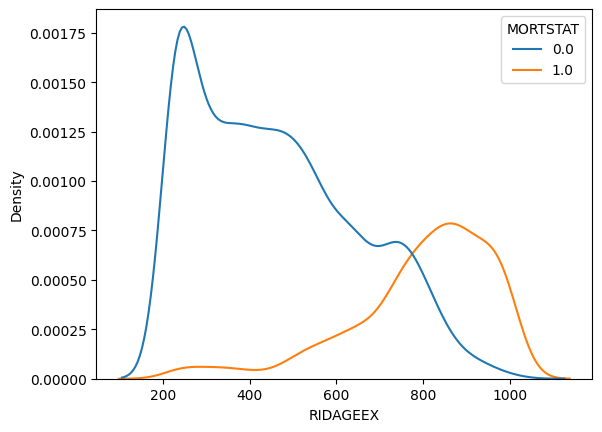

In [ ]:
# Mortality and Age
sns.kdeplot(data=df_altered, x='RIDAGEEX', hue='MORTSTAT')
# Those who are assumed alive include most of the age range, but fall off at the upper bound.
# Those who are assumed dead are mostly those who occupy the upper half of the age range.
# Age is potentially a good predictor of mortality.

<Axes: xlabel='RIDAGEEX', ylabel='PERMTH_INT'>

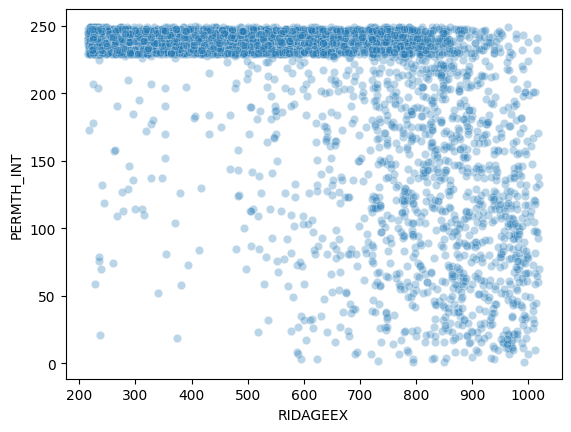

In [ ]:
# Age and life expectancy
sns.scatterplot(data=df_altered, x='RIDAGEEX', y='PERMTH_INT', alpha=.3)
# No obvious relationship here; large cluster at PERMTH_INT upper bound


<Axes: xlabel='INDFMPIR', ylabel='Density'>

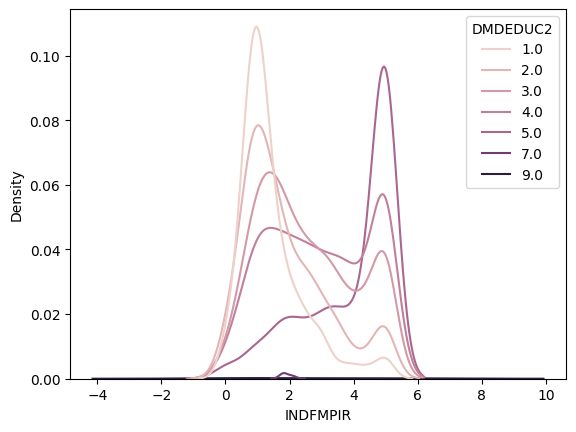

In [ ]:
# Education level and Family PIR
sns.kdeplot(data=df_altered, x='INDFMPIR', hue='DMDEDUC2')
# We can see here that, once grouped by education level, the Family PIR follows a different
# distribution. More education is associated with higher Family PIR, evidenced by the location
# of peaks. Distributions still bimodal, except for ED level 5.

<Axes: xlabel='INDFMPIR', ylabel='Density'>

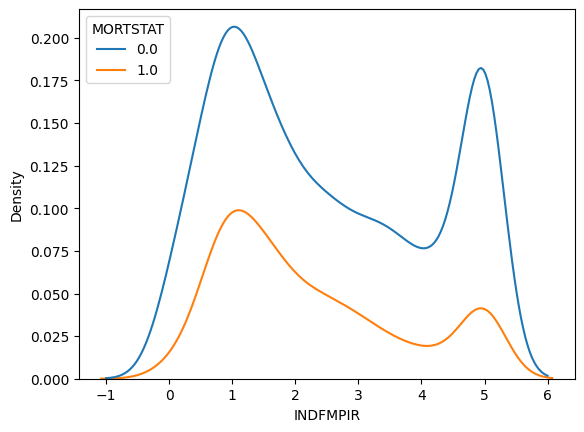

In [ ]:
# Family PIR and Mortality
sns.kdeplot(data=df_altered, x='INDFMPIR', hue='MORTSTAT')
# Those assumed alive or dead follow similarly shaped distributions across Family PIR,
# suggesting that Family PIR is not a good standalone predictor of mortality.

            INDFMPIR  PERMTH_INT
INDFMPIR    1.000000    0.088809
PERMTH_INT  0.088809    1.000000


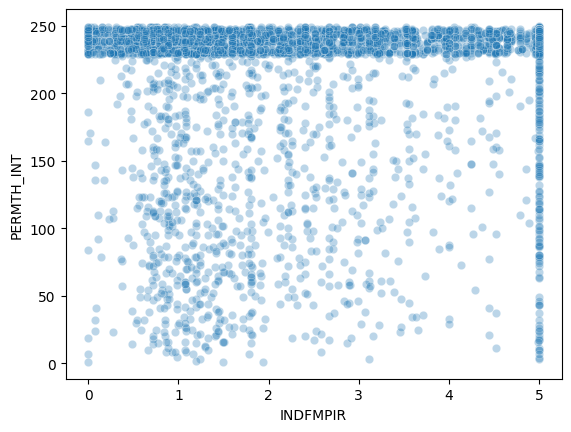

In [ ]:
# Family PIR and Life expectancy
sns.scatterplot(data=df_altered, x='INDFMPIR', y='PERMTH_INT', alpha=.3)
# Life expectancy does not appear to have a strong relationship with Family PIR, suggesting that
# income level is not predictive of life expectancy
print(df_altered.loc[:, ['INDFMPIR', 'PERMTH_INT']].corr())

        BMXBMI  BPXSY1
BMXBMI  1.0000  0.1747
BPXSY1  0.1747  1.0000


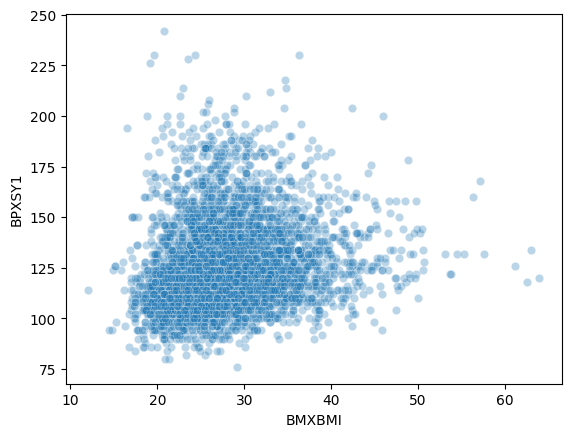

In [ ]:
# Blood Pressure and BMI
sns.scatterplot(data=df_altered, x='BMXBMI', y='BPXSY1', alpha=.3)
# Considering that BP and BMI both follow positively skewed distributions, most of the points here
# are clustered and then flare out.
print(df_altered.loc[:, ['BMXBMI', 'BPXSY1']].corr())
# The correlation between the two variables verifies that this is a weak positive linear relationship

              BMXBMI  PERMTH_INT
BMXBMI      1.000000    0.002476
PERMTH_INT  0.002476    1.000000


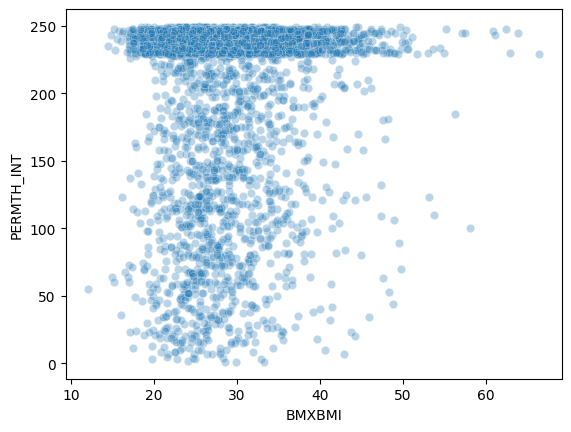

In [ ]:
# Life expectancy and BMI
sns.scatterplot(data=df_altered, x='BMXBMI', y='PERMTH_INT', alpha=.3)
# Again, the points are clustered at the life expectancy upper bound.
print(df_altered.loc[:, ['BMXBMI', 'PERMTH_INT']].corr())
# There is no correlation between the two variables

<Axes: xlabel='PERMTH_INT', ylabel='Density'>

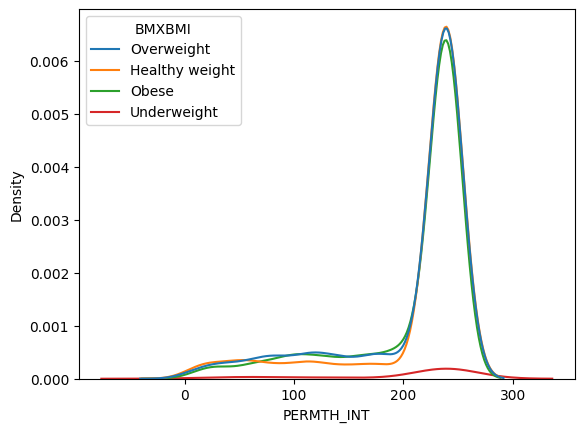

In [ ]:
# Life expectancy and BMI (cont)
sns.kdeplot(data=df_altered, x='PERMTH_INT', hue=BMI_cat.apply(bmi_category))


              BPXSY1  PERMTH_INT
BPXSY1      1.000000   -0.380497
PERMTH_INT -0.380497    1.000000


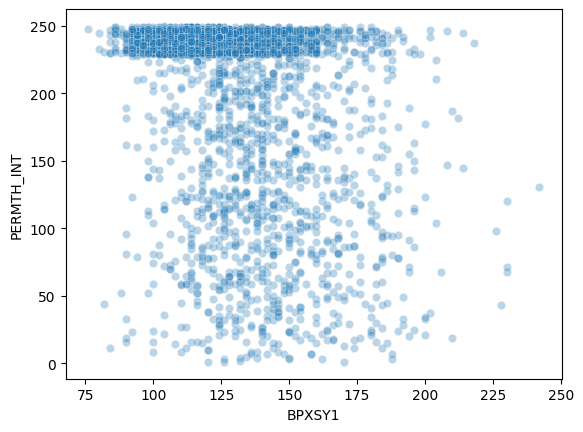

In [ ]:
# Life expectancy and blood pressure
sns.scatterplot(data=df_altered, x='BPXSY1', y='PERMTH_INT', alpha=.3)
print(df_altered.loc[:, ['BPXSY1', 'PERMTH_INT']].corr())
# There is a weak, negative correlation between the variables.

### Part 2: KNN Classification/Regression and Write-Up

1. The NHANES data contains health data collected from the civilian population. The data here were collected from 1999 to 2000. The data were collected by the Centers for Disease Control and Prevention (CDC) with the goal of assessing and improving the health of Americans. One observation is the data about one individual. There is a fair amount of missing data, which limits analysis. Additionally, the data is largely self-reported, so it is likely inaccurate in many cases. Lastly, the data only illustrates one point in time: when the participant filled out the survey. This makes it difficult to do any sort of analysis over time.

2. The variables selected are age, sex, education, income (DEMO), BMI (BMX), occupation (OCQ), blood pressure (BPQ), and heart condition (CDQ). Rationale is given in the above sections, as are the tables, scatterplots, and KDE plots. Overall, there are no surprising patterns.


3. KNN Classification below

In [ ]:
df_altered = df_altered.dropna(axis = 1) # drop NaNs

In [ ]:
from sklearn.model_selection import train_test_split
cols_to_drop = [c for c in df.columns if c.endswith("_x") or c.endswith("_y")] # identify duplicate columns
df = df.drop(columns=cols_to_drop, errors="ignore") #drop duplicate columns

print("Remaining BMI/BP columns:",[c for c in df.columns if c.startswith("BMXBMI") or c.startswith("BPXSY1")]) #confirmation that BMI and BP columns remain
var_set = ["ELIGSTAT","MORTSTAT","PERMTH_INT","RIDAGEEX",
           "RIAGENDR","DMDEDUC2","INDFMPIR",
           "BMXBMI","BPXSY1","OCQ150"] #selects the variables needed

df_altered = df.loc[:, var_set].copy() # creates new datafram containing the selected variables
df_altered = df_altered[df_altered["ELIGSTAT"] == 1] #keeps the participants eligible for mortality followup
y = df_altered['MORTSTAT'] # target variable
x = ["RIDAGEEX", #age
    "RIAGENDR", #sex
    "DMDEDUC2", #highest grade or level completed
    "INDFMPIR", #ratio of family income to poverty
    "BMXBMI", #body mass index
    "BPXSY1", #blood pressure, specifically pressure in artieries when heart beats
    "OCQ150"]
u = df_altered.loc[:, x] # features

# create train test split
u_train, u_test, y_train, y_test = train_test_split(u,y, # Feature and target variables
                                                    test_size=.2, # Split the sample
                                                    random_state=100)

Remaining BMI/BP columns: ['BMXBMI', 'BPXSY1']


In [ ]:
from sklearn.model_selection import train_test_split

x = ["RIDAGEEX","RIAGENDR","DMDEDUC2","INDFMPIR","BMXBMI","BPXSY1","OCQ150"] # variables used in the model
df_knn = df_altered[x + ["PERMTH_INT"]].dropna() # keep only what we need and drop missing rows
u = df_knn.loc[:, x] #features
y = df_knn["PERMTH_INT"] # target variable

u_train, u_test, y_train, y_test = train_test_split(u, y, test_size=0.2, random_state=100) # ensures split

MSE for 3 neighbors is 3009.9538621047177
MSE for 5 neighbors is 2860.9419595645413
MSE for 7 neighbors is 2745.5016028184214
MSE for 9 neighbors is 2657.168596279016
MSE for 11 neighbors is 2618.8761487346246
MSE for 13 neighbors is 2592.0624200539264
MSE for 15 neighbors is 2566.1455745636777
MSE for 17 neighbors is 2553.950480823562
MSE for 19 neighbors is 2495.6979790886726
MSE for 21 neighbors is 2468.1736368990314
MSE for 23 neighbors is 2453.636712950577
MSE for 25 neighbors is 2460.2532454121306
MSE for 27 neighbors is 2451.600645977468
MSE for 29 neighbors is 2458.3683887396146
MSE for 31 neighbors is 2446.9843669842357
MSE for 33 neighbors is 2455.2579791981743
MSE for 35 neighbors is 2454.6771612657503
MSE for 37 neighbors is 2457.4851380319838
MSE for 39 neighbors is 2436.2029022405864
MSE for 41 neighbors is 2421.974997293879
MSE for 43 neighbors is 2413.929277899785
MSE for 45 neighbors is 2407.645633316053
MSE for 47 neighbors is 2403.4815673474905
MSE for 49 neighbors i

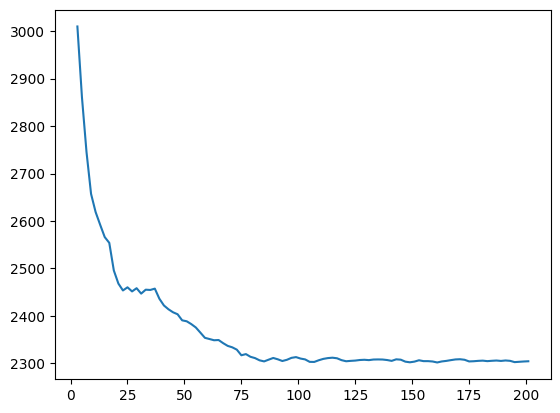

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

# calculate mean square error
def mse(y_test,y_hat):
    mse = np.sum( (y_test - y_hat) ** 2 )/len(y_test)
    return mse

# iterate through k values, checking MSE
k_grid = np.array([ (2*k+3) for k in range(0,100)])
mses = [] # List to save MSEs

for k in k_grid:
    model = KNeighborsRegressor(n_neighbors = k) # Create a model instance
    model = model.fit(u_train,y_train) # Fit the model
    y_hat = model.predict(u_test) # Predict values
    mses.append( mse(y_test, y_hat) ) # Compute and store MSE
    print( f'MSE for {k} neighbors is {mses[-1]}')

sns.lineplot(x=k_grid, y=mses) # Plot MSE
plt.show()


In [ ]:
# We'll select a k value of 75 based on the iterations through k above. The MSE is low, and k = 75 is around where the value of
# the MSE plateaus in graph. A k value of 75 is also not a huge number, meaning we should avoid overfitting.

In [ ]:
k = 75

model = KNeighborsClassifier(n_neighbors = k) # Create a model instance
model = model.fit(u_train,y_train) # Fit the model
y_hat = model.predict(u_test) # Predict values
test_acc = model.score(u_test,y_test) # Compute test accuracy
train_acc = model.score(u_train,y_train) # Compute training accuracy
print( f'Test accuracy is {test_acc}; train accuracy is {train_acc}') # Display training accuracy and test accuracy

print( pd.crosstab(y_test, y_hat)) # show confusion matrix

# Overall, the model performs well. The train accuracy is 83.3%, meaning the model predicts well over half of the cases correctly.


Test accuracy is 0.049766718506998445; train accuracy is 0.09264305177111716
col_0       7.0    11.0   16.0   19.0   23.0   41.0   47.0   49.0   51.0   \
PERMTH_INT                                                                  
1.0             0      0      0      0      0      0      0      0      0   
4.0             0      0      0      0      0      0      0      0      0   
7.0             0      0      0      0      0      0      0      0      0   
15.0            0      1      0      0      0      0      0      0      0   
16.0            0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
245.0           0      0      0      0      0      0      0      0      0   
246.0           0      0      0      0      0      0      0      0      0   
247.0           0      0      0      0      0      0      0      0      0   
248.0           0      0      0      0      0      0      0      0      0   

4. The code below performs a k-Nearest Neighbor regressor. This regressor produced a training MSE of 2223.42 and a testing MSE of 2317.05. Because these values are very close, they indicate that the model is able to generalize well and does not overfit the training data. The slightly higher error found on the test set is expected and could suggest that the unseen observations are relatively stable. However, the magnitude overall of the MSE indicates a moderate predictive accuracy, meaning that while the selected demographic and health variables contain some information about life expectancy, a large portion of the variation remains unexplained.
The value of k was selected by fitting the model across a grid of odd k values and plotting the test MSE against k. The MSE decreased quickly for smaller values of k and leveled off to form a plateau. The optimal k was chosen from the plateau region at k=75 where the test MSE was low and higher k values did not make the model perform better. Additionally, the k value in this range reduces sensitivity and avoids overfitting.

In [ ]:
y = df_knn['PERMTH_INT']  # set the target variable

u_train, u_test, y_train, y_test = train_test_split(
    u, y, test_size=.2, random_state=100) # train/test split

k = 75


model = KNeighborsRegressor(n_neighbors = k) # create kNN regressor

model = model.fit(u_train, y_train) # fit the model

y_hat = model.predict(u_test) # predict life expectancy

# compute MSE
test_mse = mse(y_test, y_hat)
train_mse = mse(y_train, model.predict(u_train))

print(f'Test MSE is {test_mse}; train MSE is {train_mse}')

Test MSE is 2317.0547066182826; train MSE is 2223.4222254054753
